# Generative Models
---

## _Zichen Wang_
## _Ma'ayan Lab Meeting_
## _Oct. 25, 2018_
---

## 0. Generative models ($G$) versus discriminative models ($D$)

- Generative models learn the **joint** probability distribution: $p(x, y)$
- Discriminative models learn **conditional** probability distribution $p(y|x)$
- Most traditional Machine Learning classifiers are Discriminative models, e.g. Logistic Regression, SVM, Decision Trees, Random Forest, LDA 
- Paired generator-discriminator examples:

| Generative  	| Discriminative  	|
|---	|---	|
| Naive Beyes  	| Logistic Regression  	|
| Hidden Markov Model  	| Conditional Random Fields  	|
| Generator in GANs  	| Discriminator in GANs  	|
|   	|   	|

---
## 1. Generative Models:


## 1.1. Naive Bayes

Gaussian Naive Bayes algorithm assumes the likelihood of the continuous features ($x_i$) is assumed to be Gaussian:

$$ p(x_i , y=y_k) \thicksim \mathcal{N}(\mu_k, \sigma_k) $$

In the learning phase, the parameters mean ($\mu_k$) and variance ($\sigma_k$) will be estimated using maximum likelihood.

In the inference phase, the predicted probability for a given class $y_k$ is given by:

$$ p(y=y_k | \mathbf{x}) = p(y=y_k) \prod_{i=1}^n p(x_i , y=y_k) $$




In [1]:
from __future__ import division, print_function
import os, sys, json
import warnings
from itertools import combinations
warnings.warn = lambda *a, **kw: False

import numpy as np
import pandas as pd
from scipy import stats
from sklearn import preprocessing, decomposition, naive_bayes, linear_model, metrics
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk', font_scale=1.2)
from sklearn.datasets import make_blobs
from matplotlib.colors import ListedColormap
from matplotlib.patches import Ellipse
np.random.seed(2018)
tf.set_random_seed(2018)
from utils import *

### What do Generative and Discriminative models _really_ learn?

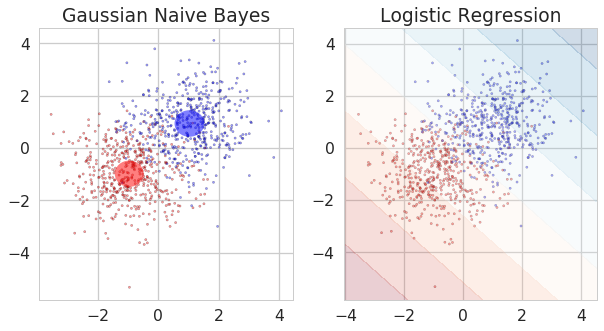

In [2]:
# Simulate some data
X, y = make_blobs(n_samples=1000, n_features=2, shuffle=False,
                 centers=[(-1,-1), (1,1)])
# Fit NB and Logit
nb = naive_bayes.GaussianNB()
logit = linear_model.LogisticRegression()
nb.fit(X, y)
logit.fit(X, y)

h = .02  # step size in the mesh
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
# just plot the dataset first
cm = plt.cm.RdBu
colors = ['#FF0000', '#0000FF']
cm_bright = ListedColormap(colors)
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
for ax in [ax1, ax2]:
    # Plot the data points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright,
               alpha=0.4,
               s=5,
               edgecolors='k')

# Plot the learned mean and variance from NB    
for c in range(2):
    mean = nb.theta_[c]
    var = nb.sigma_[c]
    e = Ellipse(xy=mean, width=var[0], height=var[1])
    ax1.add_artist(e)
    e.set_alpha(0.5)
    e.set_facecolor(colors[c])

ax1.set_title('Gaussian Naive Bayes')    

# Plot the decision function from Logit
Z2 = logit.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z2 = Z2.reshape(xx.shape)
ax2.contourf(xx, yy, Z2, cmap=cm, alpha=.2)
ax2.set_title('Logistic Regression');

## 1.2. Deep Generative Models
- VAE
- GANs
- Flow-based generative models (_TODO_)

![](https://lilianweng.github.io/lil-log/assets/images/three-generative-models.png)
*Deep Generative Models from https://lilianweng.github.io/lil-log/2018/10/13/flow-based-deep-generative-models.html*

---



### 1.2.1. Variational Autoencoder (VAE)

[Recall autoencoders (AEs)](https://nbviewer.jupyter.org/github/MaayanLab/Graph-DR/blob/master/DR-summer-2018.ipynb#2.2.2.-Parametric-methods-for-non-linear-DR) are deep nerual network models compraised of:

Encoding function:    
$$ f_\phi(\mathbf{x}) = \sigma(\mathbf{Wx} + \mathbf{b}) = \mathbf{z}$$

Decoding function:    
$$ g_\theta(\mathbf{z}) = \sigma(\mathbf{W'z} + \mathbf{b'}) = \mathbf{x'}$$

Objective/Loss function (reconstruction loss):
$$ L(\mathbf{x}, \mathbf{x'}) = ||\mathbf{x} - \mathbf{x'}||^2 $$


VAE (Kingma & Welling, 2014) introduces:
1. Probabilistic encoder $q_\phi(\mathbf{z}|\mathbf{x})$ and decoder $p_\theta(\mathbf{x}|\mathbf{z})$
2. A prior probability distribution for the latent space: $p_\theta(\mathbf{z})$
3. Latent loss defined by Kullback-Leibler divergence: $D_{KL}(q_\phi(\mathbf{z} | \mathbf{x}) \Vert p_\theta(\mathbf{z} | \mathbf{x}))$ to quantify the distance between these two probability distributions


Therefore, the loss function for VAE is composed of the reconstruction loss and the KL-divergence:

$$L_{VAE} = ||\mathbf{x} - \mathbf{x'}||^2 + D_{KL}(q_\phi(\mathbf{z} | \mathbf{x}) \Vert p_\theta(\mathbf{z} | \mathbf{x}))$$

![](https://lilianweng.github.io/lil-log/assets/images/vae-gaussian.png)
*VAE illustration from https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html*

### 1.2.2. Generative Adversarial Networks (GANs)

Introduced by Goodfellow et al., in 2014. GAN is composed of a pair of Generative($G$) and Discriminator ($D$) using adversarial training to play a minimax game between G and D. 

![](https://image.slidesharecdn.com/generativeadversarialnetworks-161121164827/95/generative-adversarial-networks-11-638.jpg?cb=1480242452)
*Source: https://www.slideshare.net/ckmarkohchang/generative-adversarial-networks*


Many variants of GANs have been developed:
- Bidirectional GAN (BiGAN)
- CycleGAN
- InfoGAN
- Wasserstein GAN
- [and many more...](https://medium.com/@jonathan_hui/gan-a-comprehensive-review-into-the-gangsters-of-gans-part-1-95ff52455672)


**Bidirectional GAN (BiGAN)** is particularly attractive in that it explicitly learn a Encoder network to map the input back to the latent space:

![BiGAN](BiGAN.png)
*Donahue et al: Adversarial Feature Learning*


# 2. Use of Generative Models

1. Learns (low dimensional) probability distribution for samples of different classes
    - Classification, e.g. predicting cell types based on gene expression vector
    - Generates synthetic samples for different classes by sampling the latent space, e.g. generate synthetic gene expression profiles for T-cells 

2. Perform interpolation of samples along different axis
    - Find the intermediate states between samples from two classes
        + Defines intermediate states along a cell differentiation process
        + Estimate psudotime for intermediate cells (from scRNA-seq) along a differentiation axis
    - Manipulate a sample along an arbitrary axis
        + [manipulate faces](https://blog.openai.com/glow/)
        + Interesting biological axes:
            - Age
            - Stemness
            - Diseasedness
            - Chemical/Genetic perturbations
                        

## How does the interpolation work?

Centoid of all class $a$ training samples in the latent space: 
$$ \mathbf{\overline{z}_a} = \frac{1}{m} \sum_{i=0}^m encode(\mathbf{x}_{a,i}) $$

Centoid of all class $b$ training samples in the latent space: 
$$ \mathbf{\overline{z}_b} = \frac{1}{n} \sum_{i=0}^n encode(\mathbf{x}_{b,i}) $$

The interpolation vector $\mathbf{z_{b \rightarrow a}}$ in the latent space from class $b$ to class $a$:
$$ \mathbf{z_{b \rightarrow a}} = \mathbf{\overline{z}_a} - \mathbf{\overline{z}_b} $$

Given any input vector of any class $\mathbf{x_c}$, we can manipulate the input with the interpolation vector by:

$$ \mathbf{z_c} = encode(\mathbf{x_c}) $$

$$ \mathbf{x_c'} = decode(\mathbf{z_c} + \alpha \mathbf{z_{b \rightarrow a}})$$    


# 3. Experiments of Generative Models with MNIST Data

## Steps:
1. Fit generative models
2. Evaluate learned latent representations of MNIST data
    - Dimensionality Reduction
    - Generated data from the latent space (z)
3. Interpolation in the latent space
    - From one class to annother
    - Manipulate class c along the a -> b vector
    


## Generative models experimented:

- [Naive Bayes](#Naive_Bayes)
- [VAE](#VAE)
- [BiGAN](#BiGAN)

In [3]:
# Load the MNIST data
mnist = input_data.read_data_sets('MNIST_data', one_hot=False)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
X_train, X_test = mnist.train.images, mnist.test.images
print (X_train.shape, X_test.shape)
labels_train = mnist.train.labels
n_samples = int(mnist.train.num_examples)

(55000, 784) (10000, 784)


In [5]:
'''Functions to qualitatively and quantitatively evaluate the interpolation effects
'''
def interpolate_from_a_to_b(Z, labels, generator, a, b, 
                            alphas=np.linspace(-3, 3, 10),
                            figsize=(14,5)
                           ):
    '''Interpolation between two classes a and b.
    Z: np.array of the latent space with shape: (n_samples, latent_dim)
    labels: array of class labels (n_samples, ) 
    '''
    # Find the centroids of the classes a, b
    z_a_avg = Z[labels == a].mean(axis=0)
    z_b_avg = Z[labels == b].mean(axis=0)
    # Pick the medoid for class a for interpolation
    z_a_med = np.median(Z[labels == a], axis=0)
    # The interpolation vector pointing from b -> a
    z_b2a = z_a_avg - z_b_avg

    x_gens = []
    for alpha in alphas:
        z_interp = z_a_med + alpha * z_b2a
        x_gens.append(generator.generate(z_interp.reshape(1, -1)))

    ax = display_mnist_images(x_gens, figsize=figsize)
    return ax, x_gens

def interpolate_from_a_to_b_for_c(Z, labels, generator, a, b, c,
                                  alphas=np.linspace(-3, 3, 10),
                                  figsize=(14,5)
                                 ):
    '''Interpolation between two classes a and b for annother class c.
    Z: np.array of the latent space with shape: (n_samples, latent_dim)
    labels: array of class labels (n_samples, ) 
    '''
    # Find the centroids of the classes a, b
    z_a_avg = Z[labels == a].mean(axis=0)
    z_b_avg = Z[labels == b].mean(axis=0)
    # Find the medoid for class c
    z_c_med = np.median(Z[labels == c], axis=0)

    # The interpolation vector pointing from b -> a
    z_b2a = z_a_avg - z_b_avg

    x_gens = []
    for alpha in alphas:
        z_interp = z_c_med + alpha * z_b2a
        x_gens.append(generator.generate(z_interp.reshape(1, -1)))

    ax = display_mnist_images(x_gens, figsize=figsize)
    return ax, x_gens

def plot_alphas_vs_probas(xs, alphas, discriminator, classes=[]):
    '''Plot the predicted probabilities for classes from the discriminator.
    xs: 2nd output from `interpolate_from_a_to_b` or `interpolate_from_a_to_b_for_c`
    alphas: array of alphas
    '''
    xs = np.array(xs)[:, 0, :]

    xs_pred_probas = discriminator.predict_proba(xs)

    fig, ax = plt.subplots()
    for c in classes:
        ax.plot(alphas, xs_pred_probas[:, c], label=str(c))
    ax.legend(loc='best')
    ax.set_ylabel('Probability')
    ax.set_xlabel('alpha')
    return ax

## Naive Bayes

In [6]:
gnb = naive_bayes.GaussianNB()
gnb.fit(X_train, labels_train)

GaussianNB(priors=None)

In [7]:
# Learned priors for each class
gnb.class_prior_

array([ 0.09898182,  0.11234545,  0.09945455,  0.10250909,  0.09649091,
        0.09067273,  0.09849091,  0.10390909,  0.09798182,  0.09916364])

In [8]:
# Learned mean of each feature per class
gnb.theta_.shape

(10, 784)

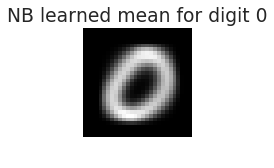

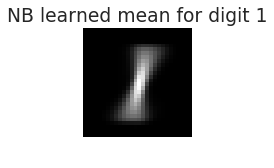

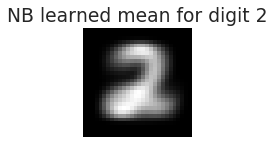

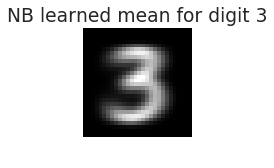

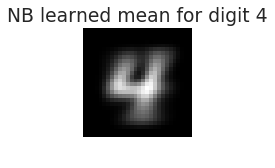

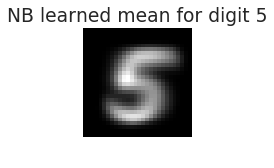

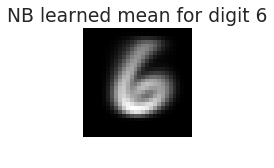

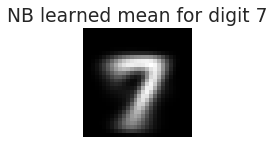

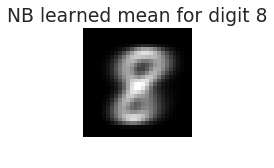

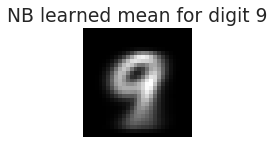

In [9]:
# Examine learned average for each digit
for i in range(10):
    ax = display_mnist_image(gnb.theta_[i].reshape(1, -1), figsize=(2,2))
    ax.set_title('NB learned mean for digit %d' % i)

In [10]:
acc = metrics.accuracy_score(mnist.test.labels, gnb.predict(X_test))
print('Accuracy: %.4f'%acc) 

Accuracy: 0.5492


In [11]:
# Compare with a simple Logistic Regression
logit = linear_model.LogisticRegression()
logit.fit(X_train, labels_train)
acc = metrics.accuracy_score(mnist.test.labels, logit.predict(X_test))
print('Accuracy (Logistic Regression): %.4f'%acc)

Accuracy (Logistic Regression): 0.9198


In [12]:
# A hack for Naive Bayes.
# Because the latent space of NB is the identical to original space, 
# .generate() method should return identity
gnb.generate = lambda x: x

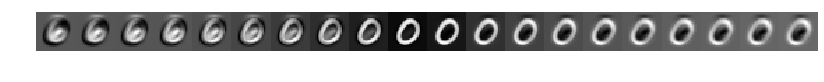

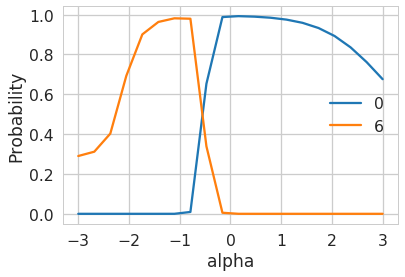

In [13]:
alphas = np.linspace(-3, 3, 20)
ax, x_gens = interpolate_from_a_to_b(X_test, mnist.test.labels, gnb, 0, 6, alphas=alphas)
ax2 = plot_alphas_vs_probas(x_gens, alphas, logit, classes=[0,6])

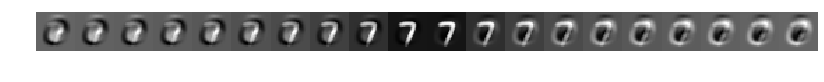

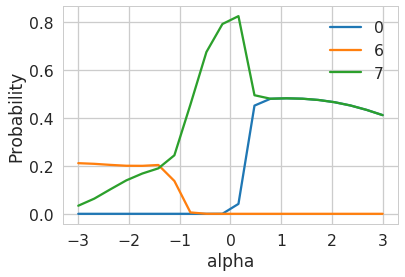

In [14]:
ax, x_gens = interpolate_from_a_to_b_for_c(X_test, mnist.test.labels, gnb, 0, 6, 7,
                                           alphas=alphas)
ax2 = plot_alphas_vs_probas(x_gens, alphas, logit, classes=[0,6,7])

## VAE

In [15]:
from autoencoder_models.VariationalAutoencoder import VariationalAutoencoder

In [16]:
# Load trained VAE models
vae2d = VariationalAutoencoder.load('trained_models/VAE_2d/')
vae20d = VariationalAutoencoder.load('trained_models/VAE_20d/')

INFO:tensorflow:Restoring parameters from trained_models/VAE_2d/model.ckpt
INFO:tensorflow:Restoring parameters from trained_models/VAE_20d/model.ckpt


In [17]:
print(vae2d.n_layers)
print(vae20d.n_layers)

[784, 500, 500, 2]
[784, 500, 500, 20]


In [18]:
# Uses trained VAE to transform MNIST into latent spaces
Z_vae2d = vae2d.transform(X_train)
Z_test_vae2d = vae2d.transform(X_test)
print (Z_vae2d.shape, Z_test_vae2d.shape)
Z_vae20d = vae20d.transform(X_train)
Z_test_vae20d = vae20d.transform(X_test)
print (Z_vae20d.shape, Z_test_vae20d.shape)

(55000, 2) (10000, 2)
(55000, 20) (10000, 20)


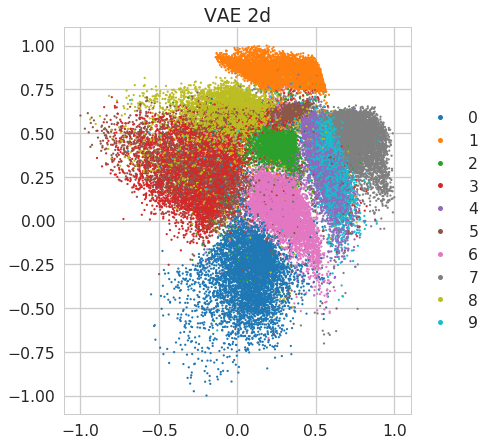

In [19]:
ax = plot_embed(Z_vae2d, labels_train)
ax.set_title('VAE 2d');

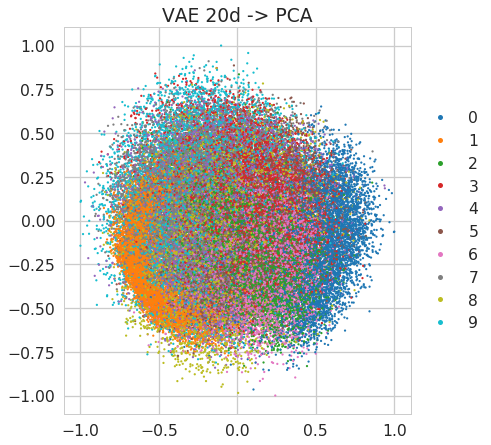

In [20]:
ax = plot_embed(decomposition.PCA(n_components=2).fit_transform(Z_vae20d), labels_train)
ax.set_title('VAE 20d -> PCA');

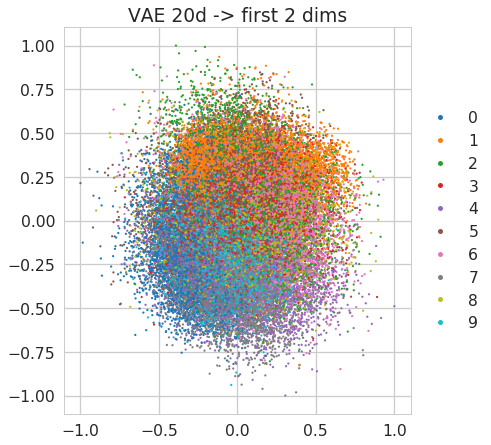

In [21]:
ax = plot_embed(Z_vae20d[:, :2], labels_train)
ax.set_title('VAE 20d -> first 2 dims');

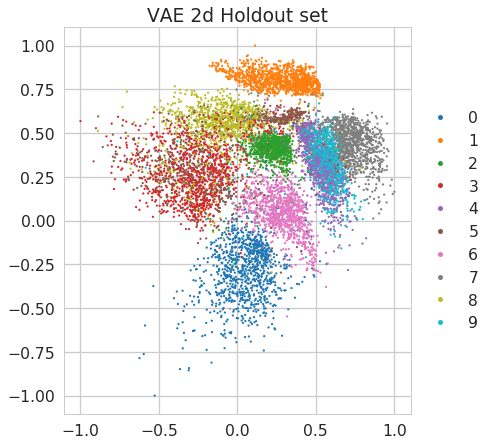

In [22]:
ax = plot_embed(Z_test_vae2d, mnist.test.labels)
ax.set_title('VAE 2d Holdout set');

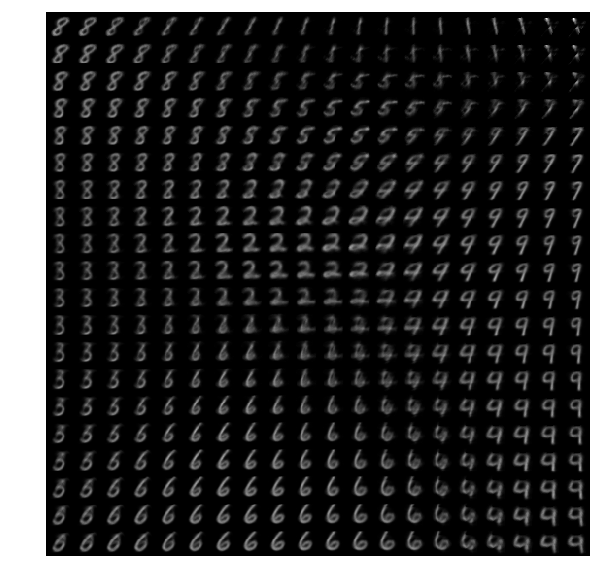

In [23]:
# Uniformly sample the VAE 2d space
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)
z_uniform = np.empty((nx, ny, 2))

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]])
        x_mean = vae2d.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(canvas, origin="upper", cmap="gray")
ax.set_axis_off()

(560, 560)


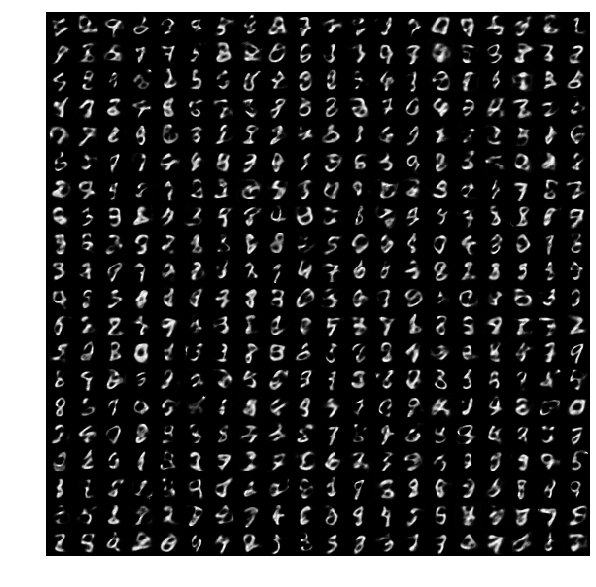

In [24]:
# Random normal sampling of the VAE 20d space 
canvas = sample_latent_space(vae20d, 20, sample_type='normal')
print(canvas.shape)
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(canvas, origin="upper", cmap="gray")
ax.set_axis_off()

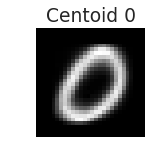

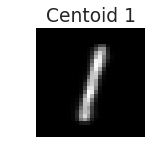

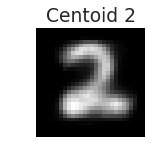

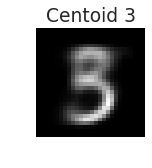

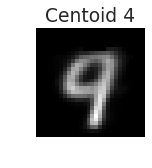

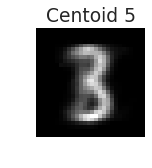

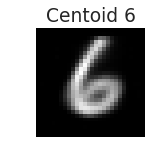

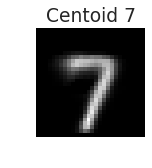

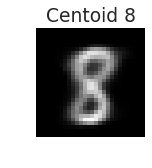

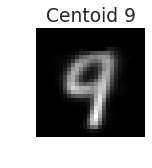

In [25]:
# Generate averages (centroid) of the digits in latent space (VAE 2d)
for i in range(10):
    z_i_avg = Z_vae2d[labels_train == i].mean(axis=0).reshape(1, -1)
    ax = display_mnist_image(vae2d.generate(z_i_avg), figsize=(2,2))
    ax.set_title('Centoid %d' % i)

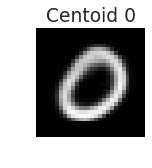

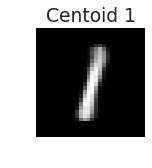

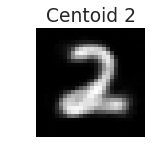

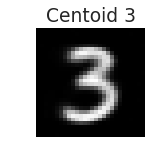

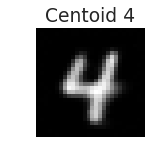

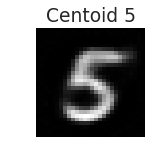

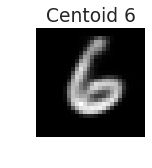

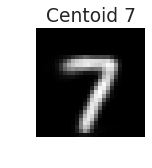

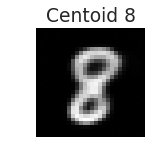

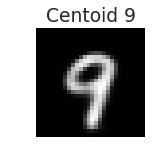

In [26]:
# Generate averages (centroid) of the digits in latent space (VAE 20d)
for i in range(10):
    z_i_avg = Z_vae20d[labels_train == i].mean(axis=0).reshape(1, -1)
    ax = display_mnist_image(vae20d.generate(z_i_avg), figsize=(2,2))
    ax.set_title('Centoid %d' % i)

Text(0.5,1,'VAE 2d')

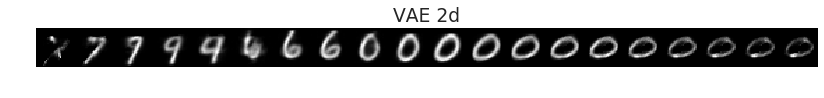

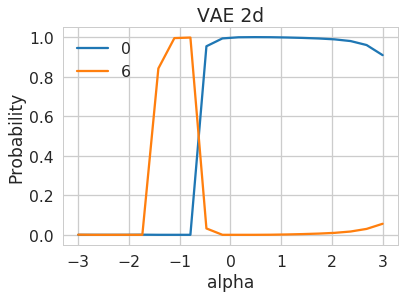

In [27]:
alphas = np.linspace(-3, 3, 20)

ax, x_gens = interpolate_from_a_to_b(Z_test_vae2d, mnist.test.labels, vae2d, 
                                     0, 6, 
                                     alphas=alphas)
ax.set_title('VAE 2d')

ax2 = plot_alphas_vs_probas(x_gens, alphas, logit, classes=[0,6])
ax2.set_title('VAE 2d')

Text(0.5,1,'VAE 2d')

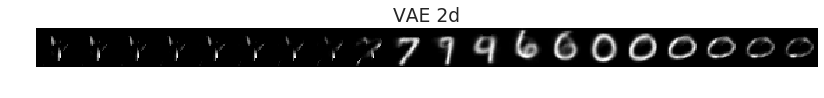

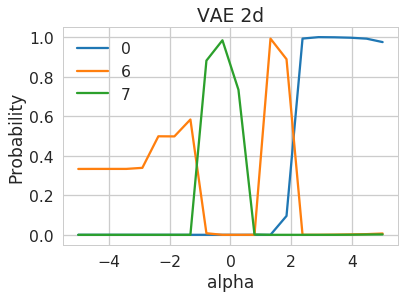

In [28]:
alphas = np.linspace(-5, 5, 20)

ax, x_gens = interpolate_from_a_to_b_for_c(Z_test_vae2d, mnist.test.labels, vae2d, 
                                           0, 6, 7,
                                           alphas=alphas)
ax.set_title('VAE 2d')

ax2 = plot_alphas_vs_probas(x_gens, alphas, logit, classes=[0,6,7])
ax2.set_title('VAE 2d')

Text(0.5,1,'VAE 20d')

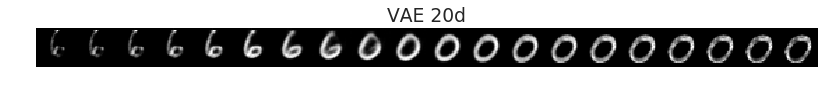

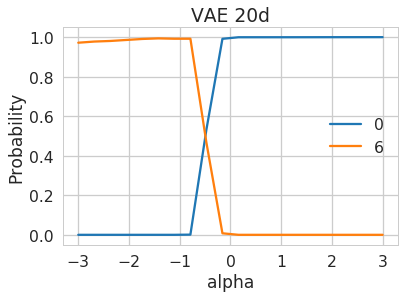

In [29]:
alphas = np.linspace(-3, 3, 20)

ax, x_gens = interpolate_from_a_to_b(Z_test_vae20d, mnist.test.labels, vae20d, 
                                     0, 6, 
                                     alphas=alphas)
ax.set_title('VAE 20d')

ax2 = plot_alphas_vs_probas(x_gens, alphas, logit, classes=[0,6])
ax2.set_title('VAE 20d')

Text(0.5,1,'VAE 20d')

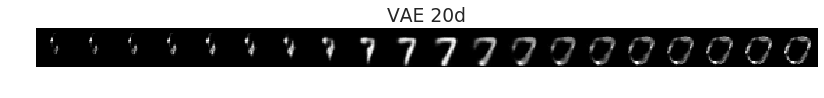

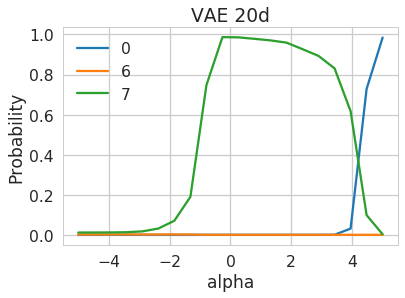

In [30]:
alphas = np.linspace(-5, 5, 20)

ax, x_gens = interpolate_from_a_to_b_for_c(Z_test_vae20d, mnist.test.labels, vae20d, 
                                           0, 6, 7,
                                           alphas=alphas)
ax.set_title('VAE 20d')

ax2 = plot_alphas_vs_probas(x_gens, alphas, logit, classes=[0,6,7])
ax2.set_title('VAE 20d')

#### Use VAE to perform interpolation between all (45) pairs of digits

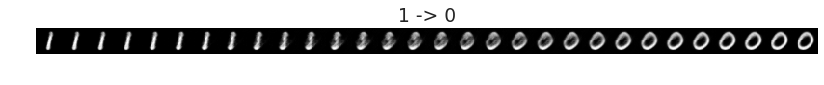

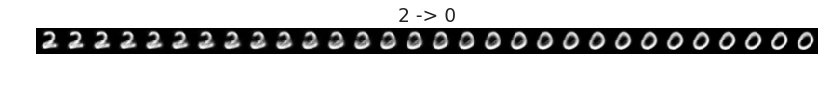

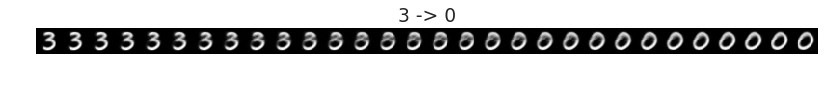

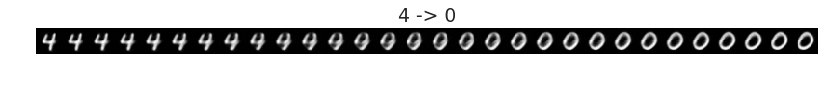

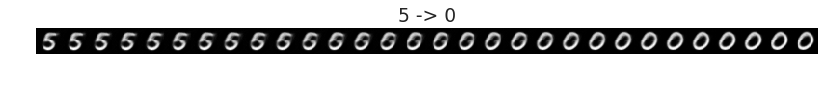

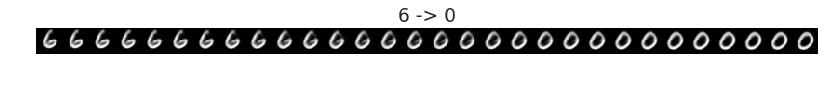

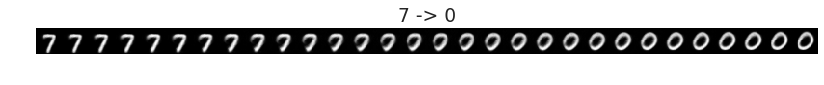

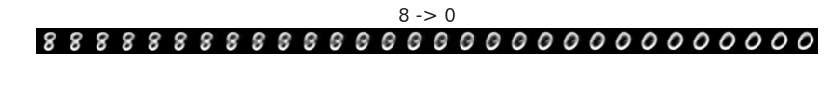

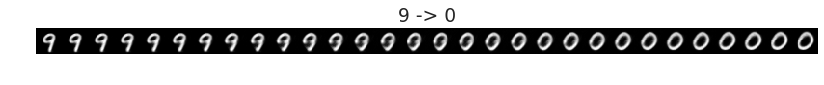

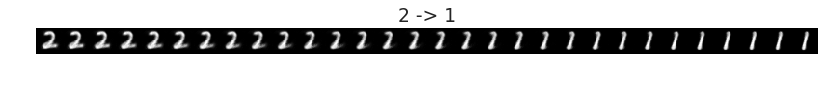

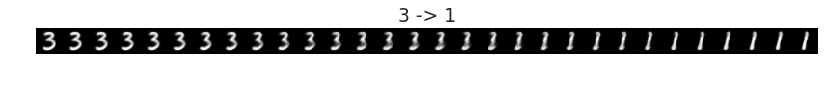

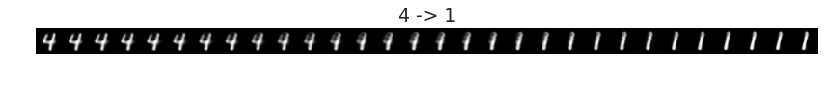

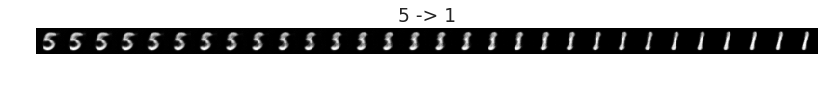

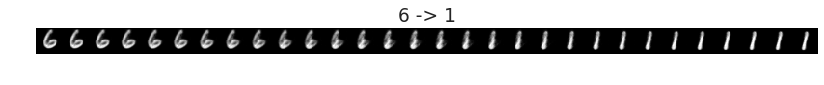

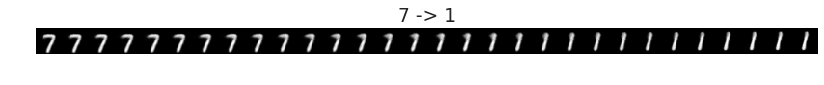

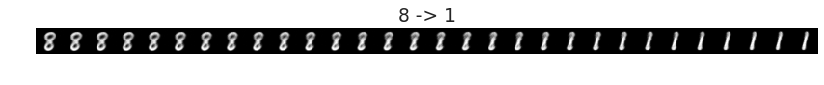

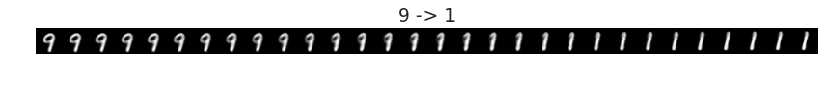

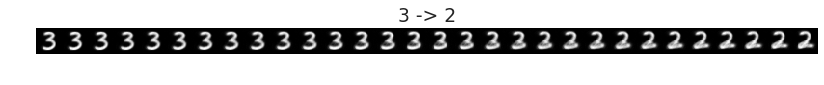

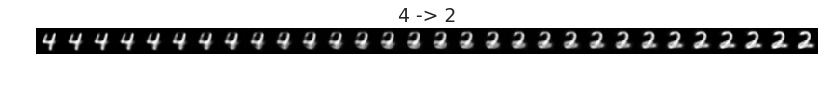

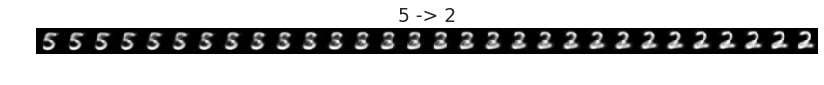

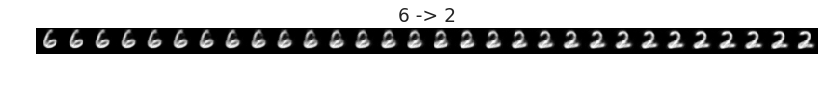

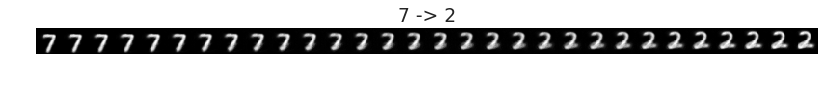

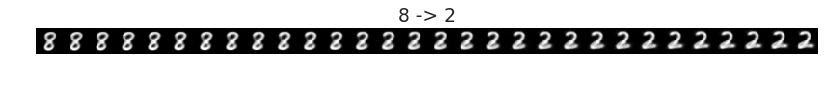

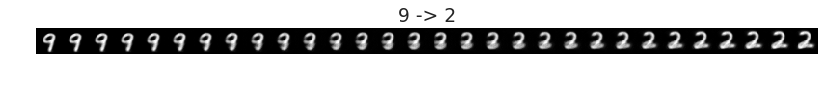

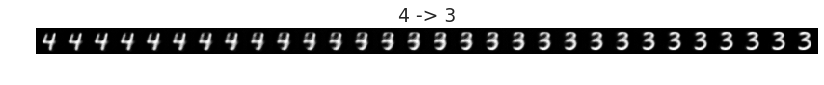

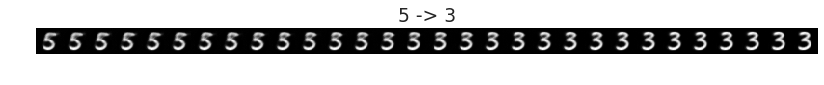

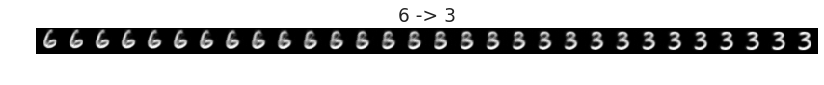

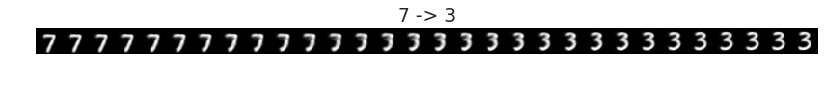

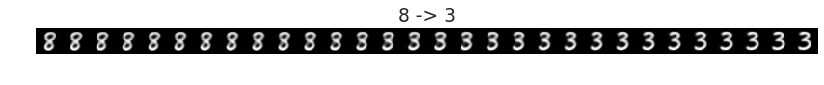

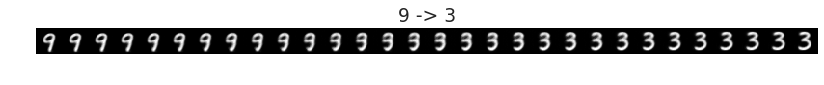

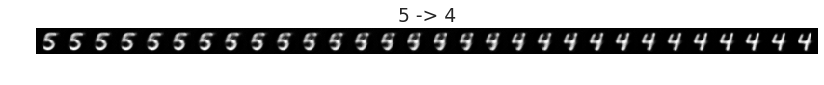

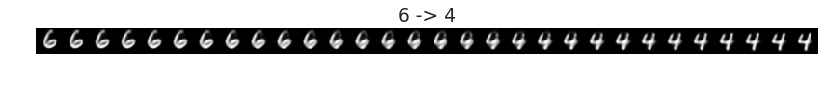

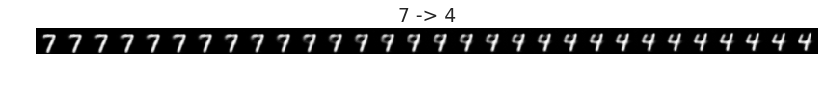

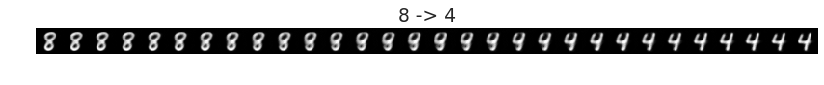

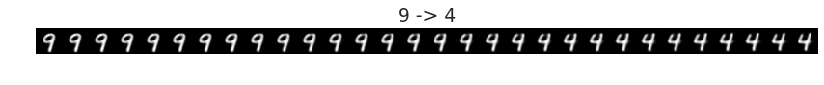

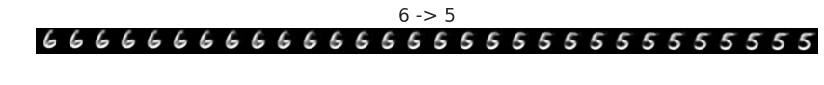

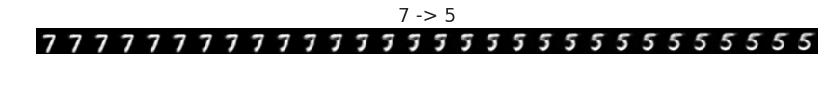

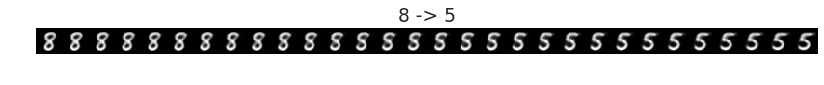

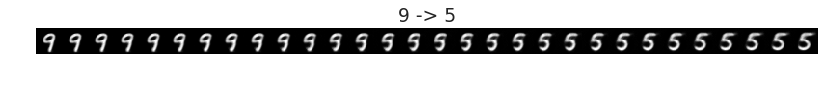

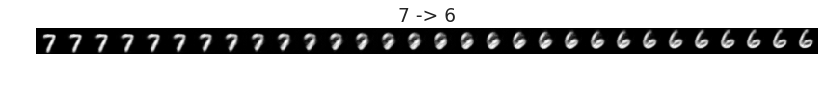

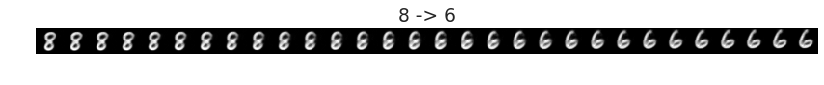

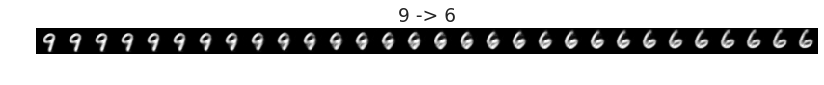

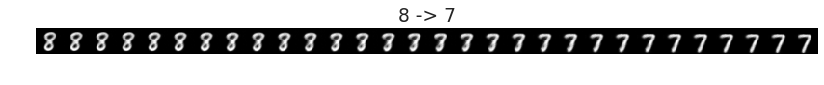

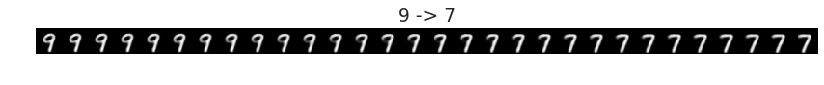

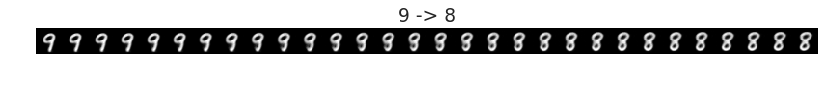

In [31]:
alphas = np.linspace(-1, 0, 30)
n = 45
canvas = np.empty((28*n, 28*len(alphas))) # To collect all the generated images

i = 0
for digit_i, digit_j in combinations(range(10), 2):
    ax, x_gens = interpolate_from_a_to_b(Z_test_vae20d, mnist.test.labels, vae20d, 
                                         digit_i, digit_j, 
                                         alphas=alphas)
    ax.set_title('%d -> %d' % (digit_j, digit_i) )
    for j in range(len(alphas)):
        x = x_gens[j]
        x = preprocessing.minmax_scale(x.T).T
        canvas[(i)*28:(i+1)*28, j*28:(j+1)*28] = x.reshape(28, 28)
    i += 1

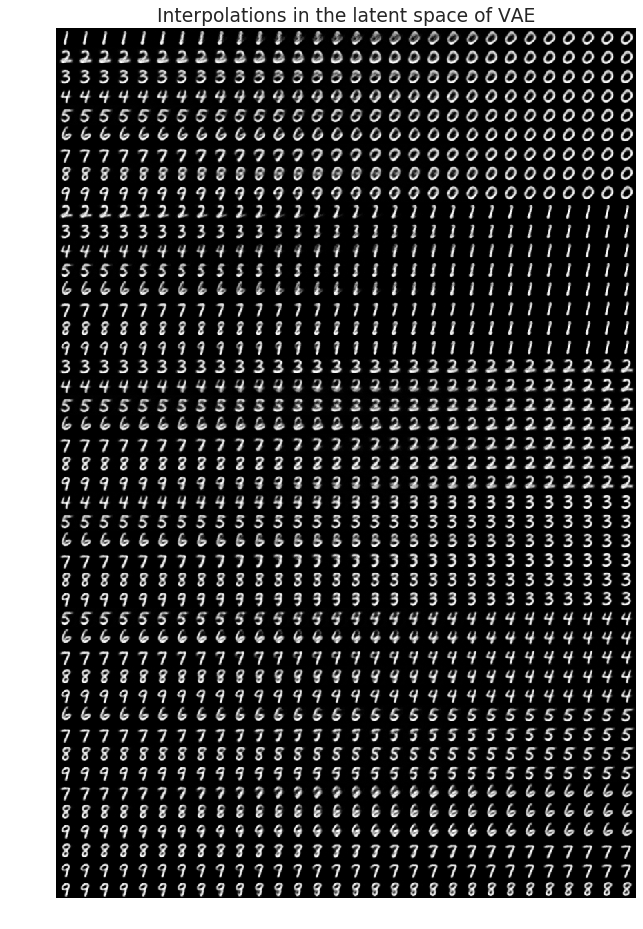

In [32]:
fig, ax = plt.subplots(figsize=(12,16))
ax.imshow(canvas, cmap="gray")
ax.set_axis_off()
ax.set_title('Interpolations in the latent space of VAE');

## BiGAN

In [33]:
from keras_gan.bigan import BiGAN

Using TensorFlow backend.


In [34]:
bigan = BiGAN.load('trained_models/bigan_20/')
bigan.params

{'g_n_layers': [784, 500, 500, 20],
 'd_n_layers': [1000, 1000, 1000],
 'learning_rate': 0.0002}

(560, 560)


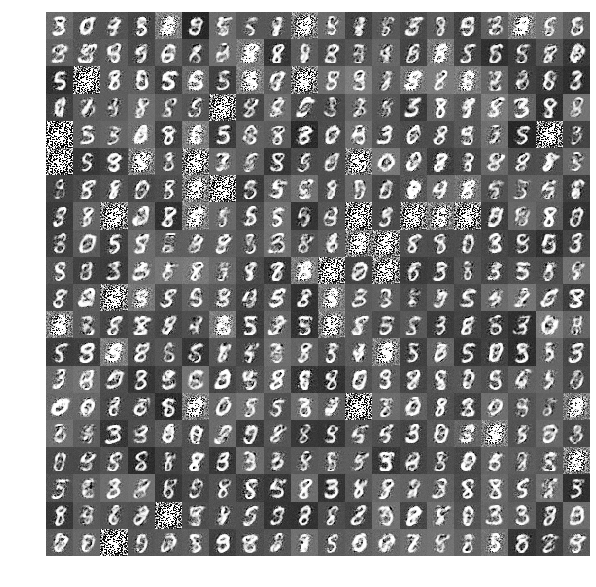

In [35]:
canvas = sample_latent_space(bigan, 20, sample_type='normal')
print(canvas.shape)
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(canvas, origin="upper", cmap="gray")
ax.set_axis_off()

In [36]:
Z_gan20d = bigan.transform(X_train)
Z_test_gan20d = bigan.transform(X_test)
print (Z_gan20d.shape, Z_test_gan20d.shape)

(55000, 20) (10000, 20)


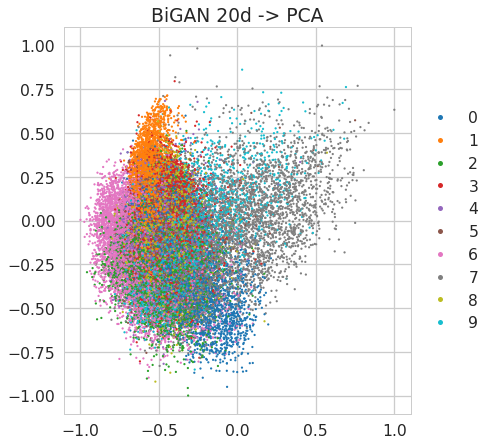

In [37]:
ax = plot_embed(decomposition.PCA(n_components=2).fit_transform(Z_gan20d), labels_train)
ax.set_title('BiGAN 20d -> PCA');

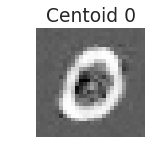

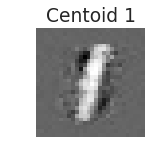

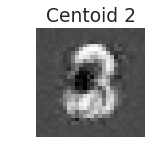

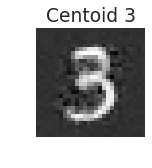

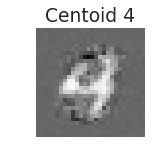

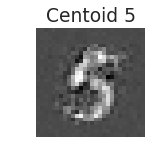

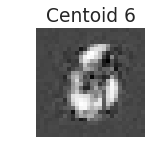

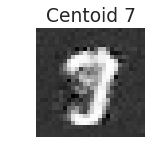

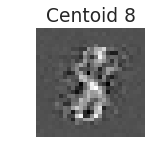

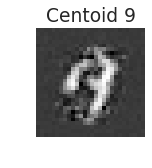

In [38]:
# Generate averages (centroid) of the digits in latent space (BiGAN 20d)
for i in range(10):
    z_i_avg = Z_gan20d[labels_train == i].mean(axis=0).reshape(1, -1)
    ax = display_mnist_image(bigan.generate(z_i_avg), figsize=(2,2))
    ax.set_title('Centoid %d' % i)

Text(0.5,1,'BiGAN 20d')

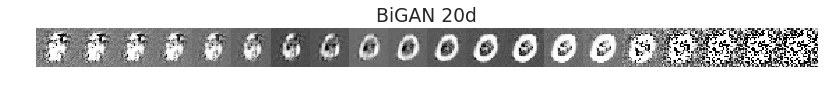

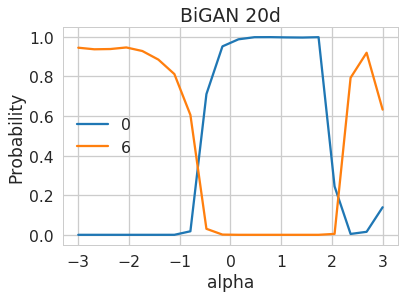

In [39]:
alphas = np.linspace(-3, 3, 20)

ax, x_gens = interpolate_from_a_to_b(Z_test_gan20d, mnist.test.labels, bigan, 
                                     0, 6, 
                                     alphas=alphas)
ax.set_title('BiGAN 20d')

ax2 = plot_alphas_vs_probas(x_gens, alphas, logit, classes=[0,6])
ax2.set_title('BiGAN 20d')

Text(0.5,1,'BiGAN 20d')

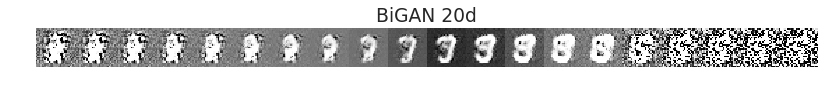

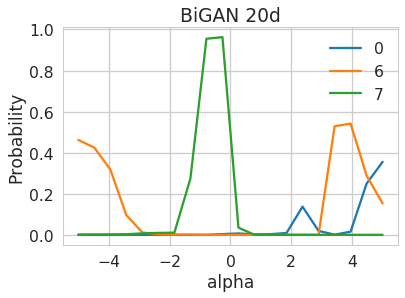

In [40]:
alphas = np.linspace(-5, 5, 20)

ax, x_gens = interpolate_from_a_to_b_for_c(Z_test_gan20d, mnist.test.labels, bigan, 
                                           0, 6, 7,
                                           alphas=alphas)
ax.set_title('BiGAN 20d')

ax2 = plot_alphas_vs_probas(x_gens, alphas, logit, classes=[0,6,7])
ax2.set_title('BiGAN 20d')

## References:

- [Ng AY & Jordan MI: On Discriminative vs. Generative classifiers](https://ai.stanford.edu/~ang/papers/nips01-discriminativegenerative.pdf)
- [Kingma & Welling: Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114)
- [Goodfellow IJ et al: Generative Adversarial Networks](https://arxiv.org/abs/1406.2661)
- [Donahue et al: Adversarial Feature Learning](https://arxiv.org/abs/1605.09782)
- [Flow-based Deep Generative Models
](https://lilianweng.github.io/lil-log/2018/10/13/flow-based-deep-generative-models.html)
- [Glow: Better Reversible Generative Models](https://blog.openai.com/glow/)
